<h1 style="text-align:center;"><b>Laboratorio 4</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

# Librerías

In [ ]:
#import sys
#!{sys.executable} -m pip install --user "folium"

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo
import pandas as pd

# Conexión

In [2]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=ETBZ-MOOV 📋 to authenticate.

[####################################-] ⌛ Authorization pending

KeyboardInterrupt: 

# Extracción de datos

## Coordenadas

In [3]:
#Areas de interes
lago_atitlan = {
    "west": -91.326256,
    "east": -91.07151,
    "south": 14.5948,
    "north": 14.750979
}
lago_amatitlan = {
    "west": -90.638065,
    "east": -90.512924,
    "south": 14.412347,
    "north": 14.493799
}

## Conexión

In [5]:
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Descarga de imágenes

In [4]:
# Fechas sin nubosidad
fechas = ["2025-02-07", "2025-02-10", "2025-02-25", "2025-02-27", "2025-03-02", "2025-03-04", "2025-03-07", "2025-03-09", "2025-03-12", "2025-03-14", "2025-03-19", "2025-03-22", "2025-03-24", "2025-03-26", "2025-04-03", "2025-04-11", "2025-04-13", "2025-04-15", "2025-04-16", "2025-04-18", "2025-04-28", "2025-05-03", "2025-05-13", "2025-05-28", "2025-07-10", "2025-07-17", "2025-07-20", "2025-07-24", "2025-08-01"]

In [ ]:
for fecha in fechas:
    try:
        # Lago Atitlán
        atitlan_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=lago_atitlan,
            temporal_extent=[fecha, fecha],  # o un rango más amplio
            bands=["B02","B03","B04", "B05", "B07", "B08", "B8A", "B11", "B12"]
        )

        result_graph = atitlan_cube.save_result(format="GTIFF")
        job = connection.create_job(result_graph)
        job.start_and_wait()
        job.download_results(f"imgs1/{fecha}.tiff")

        # Lago Amatitlán
        amatitlan_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=lago_amatitlan,
            temporal_extent=[fecha, fecha],
            bands=["B02","B03","B04", "B05", "B07", "B08", "B8A", "B11", "B12"]
        )

        result_graph = amatitlan_cube.save_result(format="GTIFF")
        job = connection.create_job(result_graph)
        job.start_and_wait()
        job.download_results(f"imgs2/{fecha}.tiff")

    except Exception as e:
        print(f"No se pudo procesar la fecha {fecha}: {e}")
        continue

No se pudo procesar la fecha 2025-02-07: name 'connection' is not defined
No se pudo procesar la fecha 2025-02-10: name 'connection' is not defined
No se pudo procesar la fecha 2025-02-25: name 'connection' is not defined
No se pudo procesar la fecha 2025-02-27: name 'connection' is not defined
No se pudo procesar la fecha 2025-03-02: name 'connection' is not defined
No se pudo procesar la fecha 2025-03-04: name 'connection' is not defined
No se pudo procesar la fecha 2025-03-07: name 'connection' is not defined
No se pudo procesar la fecha 2025-03-09: name 'connection' is not defined
No se pudo procesar la fecha 2025-03-12: name 'connection' is not defined
No se pudo procesar la fecha 2025-03-14: name 'connection' is not defined
No se pudo procesar la fecha 2025-03-19: name 'connection' is not defined
No se pudo procesar la fecha 2025-03-22: name 'connection' is not defined
No se pudo procesar la fecha 2025-03-24: name 'connection' is not defined
No se pudo procesar la fecha 2025-03-2

# Funciones para cálcular índices

In [5]:
def normalize(b):
    b_min, b_max = np.percentile(b[b > 0], (2, 98))
    return np.clip((b - b_min) / (b_max - b_min), 0, 1)

In [22]:
def calcular_ndvi(red, nir):
    red_scale = red.astype(np.float32) / 10000
    nir_scale = nir.astype(np.float32) / 10000

    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = (nir_scale - red_scale) / (nir_scale + red_scale)
        ndvi = np.where((nir_scale + red_scale) == 0, np.nan, ndvi)

    return ndvi

In [23]:
def calcular_ndwi(nir, green):
    nir_scale = nir.astype(np.float32) / 10000
    green_scale = green.astype(np.float32) / 10000

    with np.errstate(divide='ignore', invalid='ignore'):
        ndwi = (green_scale - nir_scale) / (green_scale + nir_scale)
        ndwi = np.where((green_scale + nir_scale) == 0, np.nan, ndwi)

    return ndwi

In [24]:
def calcular_savi(red, nir):
    L = 0.428
    red_scale = red.astype(np.float32) / 10000
    nir_scale = nir.astype(np.float32) / 10000

    with np.errstate(divide='ignore', invalid='ignore'):
        savi = (nir_scale - red_scale) / (nir_scale + red_scale + L) * (1 + L)
        savi = np.where((nir_scale + red_scale + L) == 0, np.nan, savi)

    return savi

## Cianobacteria

In [29]:
# Parámetros
MNDWI_threshold = 0.42
NDWI_threshold = 0.4
filter_UABS = True
filter_SSI = False  # No se usa en el código original

# Función para detección de cuerpos de agua
def wbi(r, g, b, nir, swir1, swir2):
    ws = 0
    try:
        # Índices
        ndvi = (nir - r) / (nir + r)
        mndwi = (g - swir1) / (g + swir1)
        ndwi = (g - nir) / (g + nir)
        ndwi_leaves = (nir - swir1) / (nir + swir1)
        aweish = b + 2.5 * g - 1.5 * (nir + swir1) - 0.25 * swir2
        aweinsh = 4 * (g - swir1) - (0.25 * nir + 2.75 * swir1)

        dbsi = ((swir1 - g) / (swir1 + g)) - ndvi
        wii = (nir ** 2) / r
        wri = (g + r) / (nir + swir1)
        puwi = 5.83 * g - 6.57 * r - 30.32 * nir + 2.25
        uwi = (g - 1.1 * r - 5.2 * nir + 0.4) / abs(g - 1.1 * r - 5.2 * nir)
        usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1

        # Detección de agua
        if (mndwi > MNDWI_threshold or ndwi > NDWI_threshold or
            aweinsh > 0.1879 or aweish > 0.1112 or
            ndvi < -0.2 or ndwi_leaves > 1):
            ws = 1

        # Filtro áreas urbanas y suelo desnudo
        if filter_UABS and ws == 1:
            if (aweinsh <= -0.03) or (dbsi > 0):
                ws = 0

    except Exception:
        ws = 0

    return ws

In [30]:
# Floating vegetation index
def FAI(a, b, c):
    return b - a - (c - a) * (783 - 665) / (865 - 665)   

In [31]:
# Chlorophyll-a index
def NDCI(a, b):
    return (b - a) / (b + a)

In [32]:
# Funcion CHL
def CHL(ndci):
    return 826.57 * ndci**3 - 176.43 * ndci**2 + 19 * ndci + 4.071
    

# Preparación de datos

## Visualización de un ejemplo

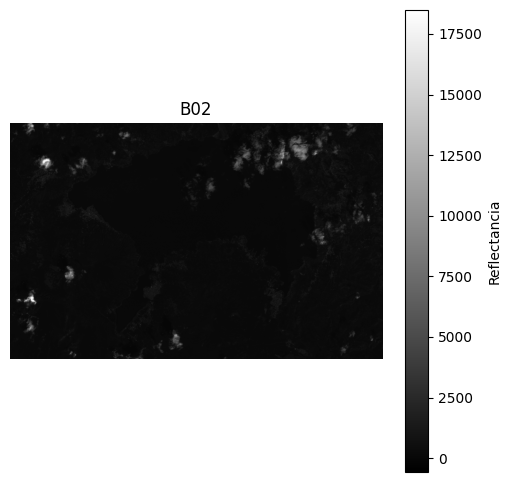

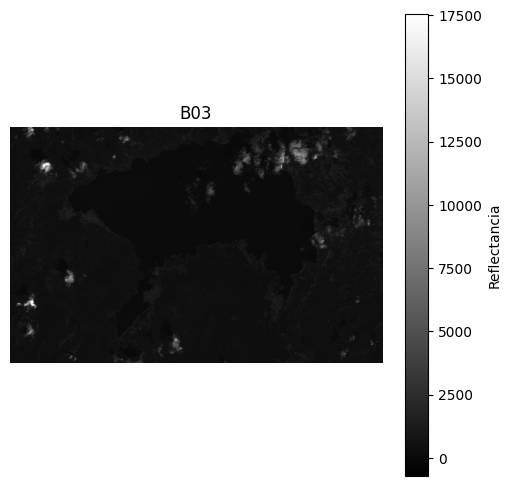

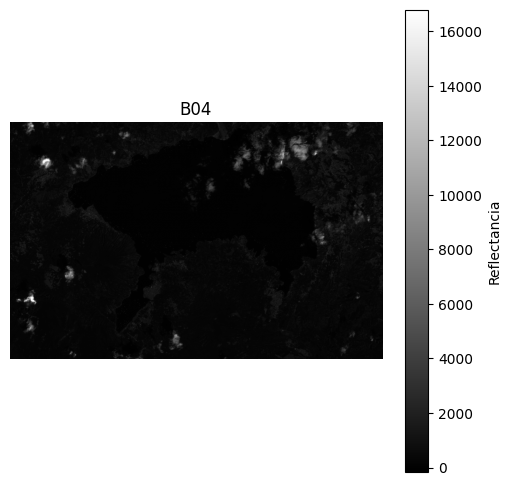

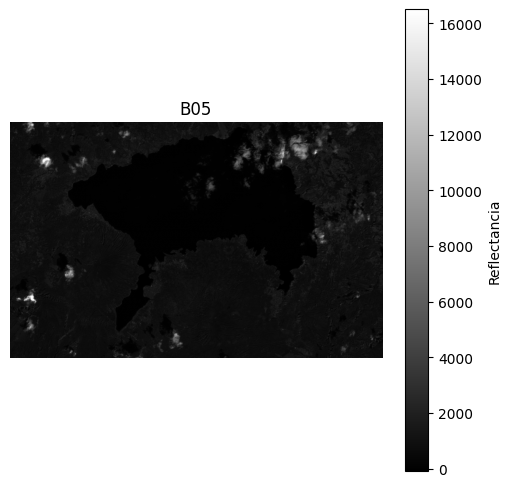

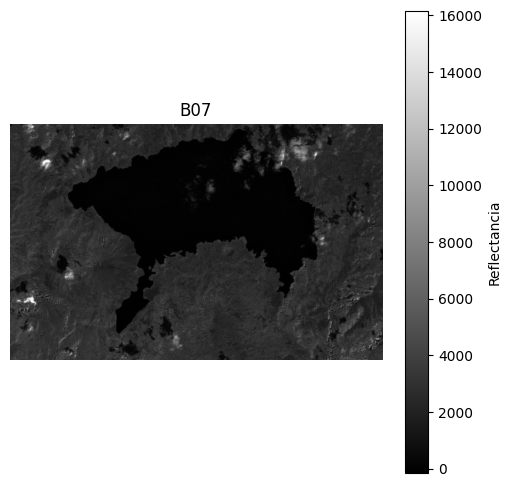

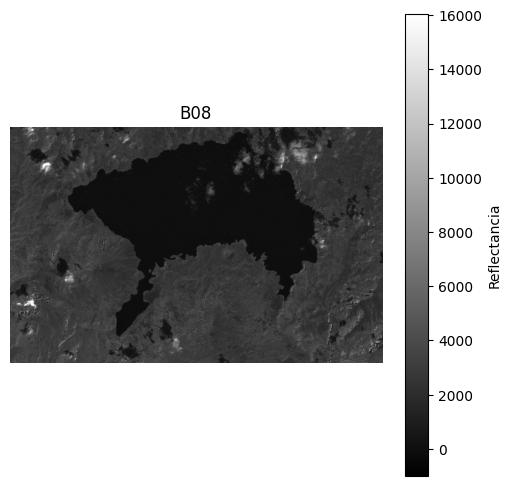

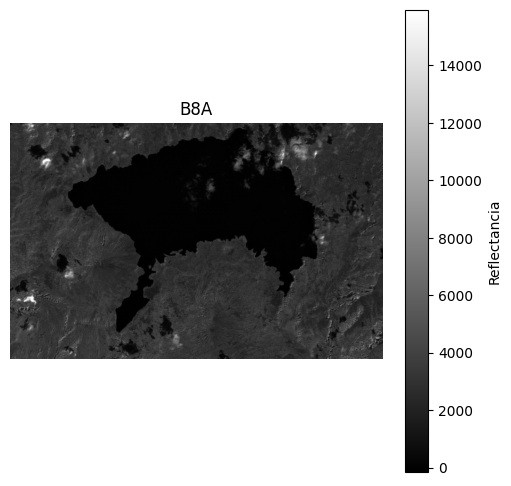

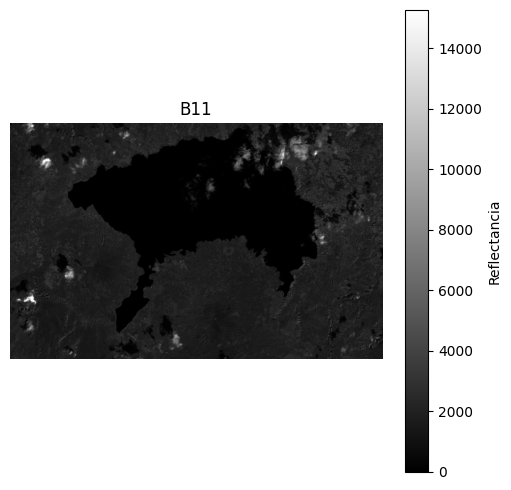

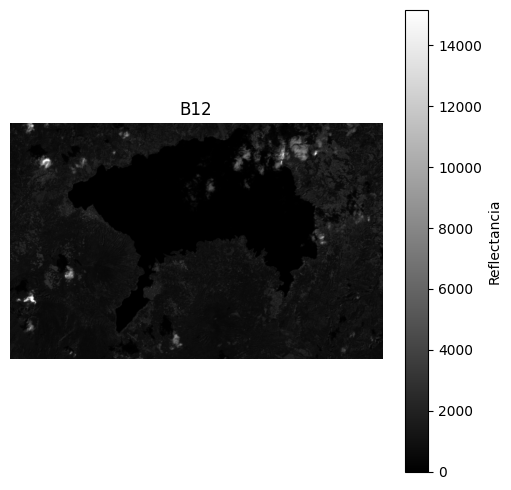

In [12]:
ruta_tif = "imgs1/2025-02-07.tiff"

with rasterio.open(ruta_tif) as src:
    bandas = src.read()  # Lee todas las bandas
    nombres = src.descriptions if src.descriptions[0] else [f"Banda {i+1}" for i in range(src.count)]
    nodata = src.nodata

# Visualizar bandas individuales
for i in range(bandas.shape[0]):
    plt.figure(figsize=(6, 6))
    img = bandas[i]
    img = np.ma.masked_where(img == nodata, img)
    plt.imshow(img, cmap='gray')
    plt.title(f"{nombres[i]}")
    plt.axis('off')
    plt.colorbar(label="Reflectancia")
    plt.show()

## Unir los datos en un DF

In [34]:
start_date = fechas[0]
end_date = fechas[-1]

dates = pd.date_range(start=start_date, end=end_date, freq="D")
df_atitlan = pd.DataFrame({"Fecha": dates})
df_amatitlan = pd.DataFrame({"Fecha": dates})

print(df_atitlan)

# You can add other columns as needed
#df["Valor"] = range(len(dates))  # Example: add a 'Value' column

# Print the DataFrame to verify
#print(df)

         Fecha
0   2025-02-07
1   2025-02-08
2   2025-02-09
3   2025-02-10
4   2025-02-11
..         ...
171 2025-07-28
172 2025-07-29
173 2025-07-30
174 2025-07-31
175 2025-08-01

[176 rows x 1 columns]


# Cálculo de índices y almacenamiento en DF

https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/cyanobacteria_chla_ndci_l1c/ 

## Índices

### Atitlan

In [33]:
for fecha in fechas:

    ruta_tif = f"imgs1/{fecha}.tiff"

    with rasterio.open(ruta_tif) as src:
        bandas = src.read()  # Lee todas las bandas
        nombres = src.descriptions if src.descriptions[0] else [f"Banda {i+1}" for i in range(src.count)]
        nodata = src.nodata

    df_atitlan.loc[df_atitlan["Fecha"] == fecha, "NoData"] = nodata

    blue = normalize(bandas[0])  # B02
    green = normalize(bandas[1])  # B03
    red = normalize(bandas[2])  # B04
    vnir_b05 = normalize(bandas[3])  # B05
    vnir_b07 = normalize(bandas[4])  # B07 
    nir = normalize(bandas[5])  # B08
    vnir_b8a = normalize(bandas[6])  # B8A
    swir_b11 = normalize(bandas[7])  # B11
    swir_b12 = normalize(bandas[8])  # B12  

    rgb = np.dstack([red, green, blue])
    ndvi = calcular_ndvi(red, nir)
    ndwi = calcular_ndwi(nir, green)
    savi = calcular_savi(red, nir)
    wbi_value = wbi(red, green, blue, nir, swir_b11, swir_b12)
    fai = FAI(red, vnir_b07, vnir_b8a)
    ndci = NDCI(red, vnir_b05)
    chl = CHL(ndci)

    df_atitlan.loc[df_atitlan["Fecha"] == fecha, "RGB"] = rgb
    df_atitlan.loc[df_atitlan["Fecha"] == fecha, "NDVI"] = ndvi
    df_atitlan.loc[df_atitlan["Fecha"] == fecha, "NDWI"] = ndwi
    df_atitlan.loc[df_atitlan["Fecha"] == fecha, "SAVI"] = savi
    df_atitlan.loc[df_atitlan["Fecha"] == fecha, "WBI"] = wbi_value
    df_atitlan.loc[df_atitlan["Fecha"] == fecha, "FAI"] = fai
    df_atitlan.loc[df_atitlan["Fecha"] == fecha, "NDCI"] = ndci 
    df_atitlan.loc[df_atitlan["Fecha"] == fecha, "CHL"] = chl



C:\Users\marcs\AppData\Local\Temp\ipykernel_41488\3186257246.py:12: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - r) / (nir + r)
C:\Users\marcs\AppData\Local\Temp\ipykernel_41488\3186257246.py:13: RuntimeWarning: invalid value encountered in divide
  mndwi = (g - swir1) / (g + swir1)
C:\Users\marcs\AppData\Local\Temp\ipykernel_41488\3186257246.py:14: RuntimeWarning: invalid value encountered in divide
  ndwi = (g - nir) / (g + nir)
C:\Users\marcs\AppData\Local\Temp\ipykernel_41488\3186257246.py:15: RuntimeWarning: invalid value encountered in divide
  ndwi_leaves = (nir - swir1) / (nir + swir1)
C:\Users\marcs\AppData\Local\Temp\ipykernel_41488\3186257246.py:19: RuntimeWarning: invalid value encountered in divide
  dbsi = ((swir1 - g) / (swir1 + g)) - ndvi
C:\Users\marcs\AppData\Local\Temp\ipykernel_41488\3186257246.py:20: RuntimeWarning: divide by zero encountered in divide
  wii = (nir ** 2) / r
C:\Users\marcs\AppData\Local\Temp\ipykernel_41488\3186257246.py:20: 

ValueError: Must have equal len keys and value when setting with an iterable

In [26]:
print(df_atitlan)

         Fecha   NoData   RGB  NDVI  NDWI  SAVI   WBI   FAI  NDCI   CHL
0   2025-02-07 -32768.0  None  None  None  None  None  None  None  None
1   2025-02-08      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2   2025-02-09      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
3   2025-02-10 -32768.0  None  None  None  None  None  None  None  None
4   2025-02-11      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
..         ...      ...   ...   ...   ...   ...   ...   ...   ...   ...
171 2025-07-28      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
172 2025-07-29      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
173 2025-07-30      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
174 2025-07-31      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
175 2025-08-01      NaN  None  None  None  None  None  None  None  None

[176 rows x 10 columns]


## Identificación de cianobacterias

In [ ]:
'''# Ejemplo de uso con bandas (deben estar definidas previamente)
# B02, B03, B04, B05, B07, B08, B8A, B11, B12 = ...
water = wbi(B04, B03, B02, B08, B11, B12)
FAIv = FAI(B04, B07, B8A)
NDCIv = NDCI(B04, B05)
chl = 826.57 * (NDCIv ** 3) - 176.43 * (NDCIv ** 2) + 19 * NDCIv + 4.071

trueColor = [3 * B04, 3 * B03, 3 * B02]

# Colormap
if water == 0:
    color = trueColor
elif FAIv > 0.08:
    color = [233/255, 72/255, 21/255]
elif chl < 0.5:
    color = [0, 0, 1.0]
elif chl < 1:
    color = [0, 0, 1.0]
elif chl < 2.5:
    color = [0, 59/255, 1]
elif chl < 3.5:
    color = [0, 98/255, 1]
elif chl < 5:
    color = [15/255, 113/255, 141/255]
elif chl < 7:
    color = [14/255, 141/255, 120/255]
elif chl < 8:
    color = [13/255, 141/255, 103/255]
elif chl < 10:
    color = [30/255, 226/255, 28/255]
elif chl < 14:
    color = [42/255, 226/255, 28/255]
elif chl < 18:
    color = [68/255, 226/255, 28/255]
elif chl < 20:
    color = [68/255, 226/255, 28/255]
elif chl < 24:
    color = [134/255, 247/255, 0]
elif chl < 28:
    color = [140/255, 247/255, 0]
elif chl < 30:
    color = [205/255, 237/255, 0]
elif chl < 38:
    color = [208/255, 240/255, 0]
elif chl < 45:
    color = [208/255, 240/255, 0]
elif chl < 50:
    color = [251/255, 210/255, 3/255]
elif chl < 75:
    color = [248/255, 207/255, 2/255]
elif chl < 90:
    color = [134/255, 247/255, 0]
elif chl < 100:
    color = [245/255, 164/255, 9/255]
elif chl < 150:
    color = [240/255, 159/255, 8/255]
elif chl < 250:
    color = [237/255, 157/255, 7/255]
elif chl < 300:
    color = [239/255, 118/255, 15/255]
elif chl < 350:
    color = [239/255, 101/255, 15/255]
elif chl < 450:
    color = [239/255, 100/255, 14/255]
elif chl < 500:
    color = [233/255, 72/255, 21/255]
else:
    color = [233/255, 72/255, 21/255]

# 'color' contiene el RGB resultante'''

## Otros Datos